In [9]:
from gibbs.dataclass import GibbsResult,get_results
import numpy as np
from gibbs.utils import simple_purify_hamiltonian,printarray,spectral_dec,candidate
import matplotlib.pyplot as plt
from gibbs.learning.bayesian_learning_v2 import BayesianLearning
from gibbs.learning.constraint_matrix import ConstraintMatrixFactory
from gibbs.plots.plots import compare_preparations, axis_locality,preparation
import plotly.express as px
from qiskit.quantum_info import state_fidelity

%load_ext autoreload
%autoreload 2
gibbsresults = get_results("../saved_simulations/turbo/simplerandomcfields")

print(len(gibbsresults), *(g.betas[-1] for g in gibbsresults))
print(gibbsresults[0].klocality)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
14 0.43999999999999995 0.43999999999999995 0.43999999999999995 0.43999999999999995 0.43999999999999995 0.43999999999999995 0.43999999999999995 0.43999999999999995 0.43999999999999995 0.43999999999999995 0.43999999999999995 0.43999999999999995 0.43999999999999995 0.43999999999999995
3


(207,) (207,) (207,)


/home/drudis/python_environements/gibbsvenv/lib64/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning:

Casting complex values to real discards the imaginary part



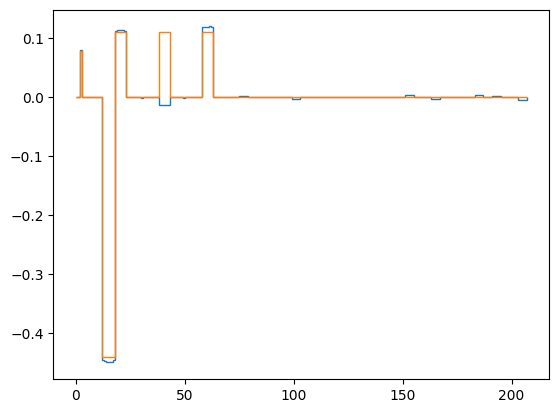

In [14]:
index = 1
plt.stairs(gibbsresults[index].cfaulties[-1])
plt.stairs(gibbsresults[index].coriginal*gibbsresults[index].betas[-1])
preparation(gibbsresults[3])

In [14]:
# num_qubits = 5
# cmat_factory=ConstraintMatrixFactory(num_qubits,2,3,False)
# c_original_prior = np.zeros(cmat_factory.learning_basis.size)
# c_original_prior[:5] = -1
# c_original_prior[30:35] = 0.25
# c_original_prior[45:50] = 0.25
# c_original_prior[65:70] = 0.25
# control_fields = [np.zeros(cmat_factory.learning_basis.size)]
# for i in range(10):
#     cf = np.zeros(cmat_factory.learning_basis.size);cf[i*5] = 0.3
#     control_fields.append(cf)

# prior_std = 5e-2
# prior_cfield_std = 1e-4
# c_preparation = c_original_prior + np.random.normal(0,prior_std,c_original_prior.shape)
# control_fields_noisy = [v+np.random.normal(0,prior_cfield_std,c_original_prior.shape) for v in control_fields]

# states = [simple_purify_hamiltonian((c_preparation+v_noisy,cmat_factory.learning_basis),noise=0) for v_noisy in control_fields_noisy]

# shots = 1e5
# initial_arguments = {
#     "states":states,
#     "control_fields": control_fields,
#     "cmat_factory": cmat_factory,
#     "prior_mean": c_original_prior,
#     "prior_covariance": prior_std**2,
#     "prior_cfield_std": 1e-8,
#     "shots": shots,
#     }
# bl = BayesianLearning(**initial_arguments)

In [4]:
timestep = -1
c_original_prior = gibbsresults[0].coriginal*gibbsresults[0].betas[timestep]
states = [g.state_ansatz(timestep) for g in gibbsresults]
control_fields = [g.coriginal-gibbsresults[0].coriginal for g in gibbsresults]
control_error_vectors = [np.real((r.cfaulties[timestep]-gibbsresults[0].cfaulties[timestep]) - (r.coriginal - c_original_prior)) for r in gibbsresults]
control_noise=np.concatenate(control_error_vectors)
control_noise = control_noise[control_noise>1e-8]
control_noise = np.std(control_noise)
prep_noise = np.std(gibbsresults[0].cfaulties[timestep]-c_original_prior)
print(f"We get control noise and preparation noise of {control_noise:.3e} and {prep_noise:.3e} respectively.")

cmat_factory=ConstraintMatrixFactory(gibbsresults[0].num_qubits,3,4,False)
shots = 1e4
initial_arguments = {
    "states":states,
    "control_fields": [c[:cmat_factory.learning_basis.size] for c in control_fields],
    "cmat_factory": cmat_factory,
    "prior_mean": c_original_prior[:cmat_factory.learning_basis.size],
    "prior_covariance": 1e-1,
    "prior_cfield_std": 1e-2,
    "shots": shots,
    }
bl = BayesianLearning(**initial_arguments)

We get control noise and preparation noise of 2.594e-01 and 1.905e-02 respectively.


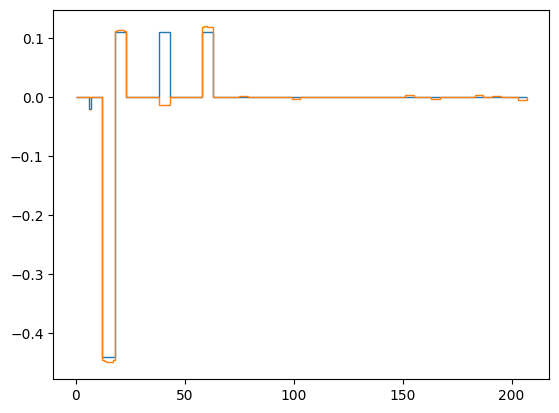

In [6]:
plt.stairs(c_original_prior)
plt.stairs(gibbsresults[0].cfaulties[timestep])
# plt.stairs(c_preparation)

In [17]:
K = bl.constraint_matrix(0)
E = bl.error_matrix(0)

[-0.97013965 -0.93666096 -0.92164284 -1.04402373 -0.99694987  0.05774634
 -0.02693479 -0.0355486  -0.01033989 -0.01907965 -0.06252226  0.06166062
 -0.05668474  0.06314653  0.05785561  0.07483794 -0.02910444  0.07070758
  0.00661928 -0.06881409  0.03014325 -0.02766034 -0.09204137  0.01462254
 -0.06336768  0.03455601 -0.08035578 -0.06564449 -0.02129735  0.08696138
  0.33616464  0.24039768  0.28251426  0.35119217  0.25366412  0.17173108
  0.04349082  0.00872184  0.01401712 -0.04378301 -0.02176179  0.07894448
  0.05123121  0.00673396 -0.08290756  0.18073041  0.2861973   0.27260443
  0.14432403  0.30754654 -0.07828665]


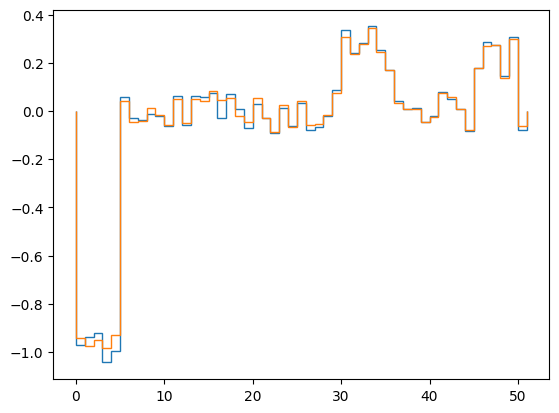

In [18]:
s,v = spectral_dec(K)
can = candidate(v[-1],c_original_prior)
print(can)
plt.stairs(can)
plt.stairs(c_preparation)

In [19]:
print(K.shape,E.shape,bl.size)
print(bl.size,bl.control_fields[0].shape)

(159, 51) (159, 51, 447) 51
51 (51,)


In [20]:
cost_fun,x0 = bl.cost_function([0,1,2])
%timeit cost_fun(x0)
print(x0.shape)

48.7 ms ± 13.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(204,)


In [21]:
from scipy.optimize import minimize
x1 = np.concatenate([can] + [control_fields[i] for i in [0,1,2]])
print(bl.terms_cost_function([0,1,2],x0))
print(bl.terms_cost_function([0,1,2],x1))

def callback(x):
    print(np.min(x),np.max(x))
    print(bl.terms_cost_function([0,1,2],x))

x_best,cost_best = None, np.inf

for r in np.linspace(0,1,50):
    x_guess = r*x0 + (1-r)*x1
    cost_guess = cost_fun(x_guess)
    if cost_guess<cost_best:
        x_best=x_guess
        cost_best = cost_guess
        print(r,cost_best)

result = minimize(cost_fun,x1,options={"maxiter": 1e5, "xrtol": 1e-3, "disp": True},callback=callback)

(225042.83960501477, 0.0)
(1385.1356839276536, 1834.9811277453737)
0.0 3220.1168116730273
0.02040816326530612 3175.9049374809947


KeyboardInterrupt: 

In [22]:
print(bl.terms_cost_function([0,1,2],result.x))
plt.stairs(result.x)
# plt.stairs(gibbsresults[0].cfaulties[-1])
plt.stairs(c_preparation)
plt.stairs(c_original_prior)
print(result.x.shape,gibbsresults[0].cfaulties[-1].shape,gibbsresults[0].coriginal.shape)

NameError: name 'result' is not defined

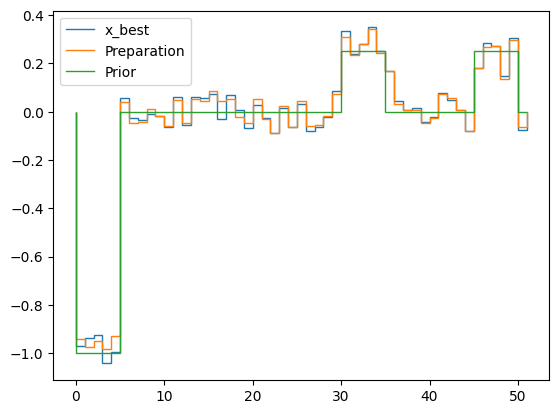

In [24]:
# plt.stairs(result.x[:bl.size],label="Reconstruction",lw=2)
plt.stairs(x_best[:bl.size],label="x_best")
plt.stairs(c_preparation,label="Preparation")
plt.stairs(c_original_prior,label="Prior")
plt.legend()